In [1]:
import tqdm
import numpy as np
import scipy.stats
import sklearn
import sklearn.cluster
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('ticks')
palette = sns.color_palette("RdBu_r", n_colors=25)

In [2]:
b = 100
n = 300
cov = np.array([[1, 0.5], [0.5, 1]])

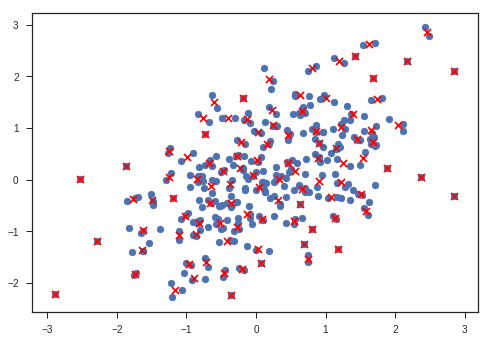

In [3]:
XY = scipy.stats.multivariate_normal(mean=[0, 0], cov=cov).rvs(n)
X, Y = np.split(XY, [1], axis=1)
XY_ = np.array([[x, y] for x in X for y in Y]).reshape(n**2, 2)
UV = sklearn.cluster.KMeans(b).fit(XY).cluster_centers_
U, V = np.split(UV, [1], axis=1)

plt.scatter(X, Y)
plt.scatter(U, V, c='r', marker='x')

In [4]:
def norm(mean, sigma):
    cov = np.eye(len(mean)) * sigma
    return lambda x: scipy.stats.multivariate_normal.pdf(x, mean=mean, cov=cov)

sigma = 1
bases = [norm(uv, sigma) for uv in UV]

In [5]:
phi = np.array([b(XY_) for b in bases])
H = phi.dot(phi.transpose()) / n ** 2
h = np.mean([b(XY) for b in bases], axis=1)

In [6]:
lamb = 0.00001
alpha = np.linalg.solve(H + lamb * np.eye(b), h)
alpha[alpha < 0] = 0

In [7]:
np.mean(np.log([np.sum([alpha[i] * bases[i](xy) for i in range(b)]) for xy in XY]))

1.678010024374089

In [8]:
-0.5 * np.log(1 - cov[0, 1]**2 / cov[0, 0] / cov[1, 1])

0.14384103622589045